In [ ]:
%pip install -r requirements.txt

In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from data_gathering import get_traffic, get_active_cameras_by_segment, get_all_cameras

## Parameters

Get all the segments for which the two versions operate simultaneously

In [8]:
cameras = get_all_cameras()
cameras_per_segments = cameras.groupby('segment_id')['hardware_version'].nunique()
cameras_per_segments.sort_values(ascending=False)[0:10]

segment_id
9000001038    2
9000002477    2
9000002156    2
9000002105    2
9000004731    1
9000004732    1
9000004733    1
9000004736    1
9000004737    1
9000004739    1
Name: hardware_version, dtype: int64

In [59]:
segment_id = 9000002156
yesterday = (datetime.now() - timedelta(2))

cameras = get_active_cameras_by_segment(segment_id)
start_period = "2023-09-08 00:00:00Z"
end_period = yesterday.strftime('%Y-%m-%d %H:%M:%SZ')

transportation_modes = ['car','bike','pedestrian','heavy']
direction_modes = [mode + '_lft' for mode in transportation_modes] + [mode + '_rgt' for mode in transportation_modes]

## Get Telraam data 

In [60]:
burel = pd.DataFrame()
for version in cameras:
    burel_tmp = get_traffic(cameras[version], start_period, end_period, level='instances')
    burel_tmp['version'] = version
    burel = pd.concat([burel, burel_tmp], ignore_index=True)

#burel.to_csv(f"data/burel_{yesterday.strftime('%Y%m%d')}.csv", index=False)

In [61]:
burel.groupby('version')['version'].count()

version
v1    1289
v2     669
Name: version, dtype: int64

In [62]:
burel.columns

Index(['instance_id', 'segment_id', 'date', 'interval', 'uptime', 'heavy',
       'car', 'bike', 'pedestrian', 'heavy_lft', 'heavy_rgt', 'car_lft',
       'car_rgt', 'bike_lft', 'bike_rgt', 'pedestrian_lft', 'pedestrian_rgt',
       'direction', 'car_speed_hist_0to70plus', 'car_speed_hist_0to120plus',
       'timezone', 'v85', 'version'],
      dtype='object')

In [63]:
burel.tail()

,instance_id,segment_id,date,interval,uptime,heavy,car,bike,pedestrian,heavy_lft,...,bike_lft,bike_rgt,pedestrian_lft,pedestrian_rgt,direction,car_speed_hist_0to70plus,car_speed_hist_0to120plus,timezone,v85,version
1953,7238,-1,2023-10-31T15:00:00.000Z,hourly,0.649167,11.019174,24.870927,7.793786,4.580214,6.315954,...,4.72693,3.066856,4.580214,0.000000,0,"[6.5794237064, 12.5214319797, 30.6041890296, 5...","[6.5794237064, 0.0, 0.0, 12.5214319797, 24.072...",Europe/Brussels,34.5,v1
1954,7238,-1,2023-10-31T16:00:00.000Z,hourly,0.214444,6.101695,18.305085,9.890110,3.050847,3.050847,...,9.89011,0.000000,0.000000,3.050847,0,"[16.6666666667, 16.6666666667, 66.6666666667, ...","[0.0, 16.6666666667, 0.0, 16.6666666667, 33.33...",Europe/Brussels,25.5,v1
1955,7238,-1,2023-10-31T17:00:00.000Z,hourly,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,v1
1956,7238,-1,2023-10-31T18:00:00.000Z,hourly,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,v1
1957,7238,-1,2023-10-31T19:00:00.000Z,hourly,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,v1


## Analysis

Ideas :
- daily aggregation and comparison 
    - global (or just cars + heavy)
    - by transportation mode
    - by directions
- by moment of time :
    - day of week
    - hour
- uptime differences ?
- v85 differences ?
- directions

In [64]:
#burel = pd.read_csv('data/burel_20231018.csv')

burel['date'] = pd.to_datetime(burel['date'])
burel['day'] = burel['date'].dt.date
burel['hour'] = burel['date'].dt.hour

dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
burel['day_of_week'] = burel['date'].dt.strftime('%A')
burel['day_of_week'] = pd.Categorical(burel['day_of_week'], categories=dow_order)


burel = burel.query('uptime > 0.5')

### Uptime

<Axes: xlabel='day', ylabel='uptime'>

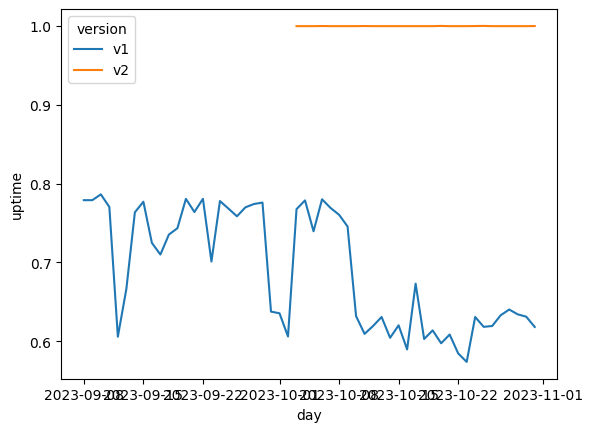

In [65]:
id_var = ['day','version']
median_uptime = burel.groupby(id_var)['uptime'].median().reset_index()
sns.lineplot(median_uptime, x="day", y="uptime", hue="version", errorbar=None)

<Axes: ylabel='uptime'>

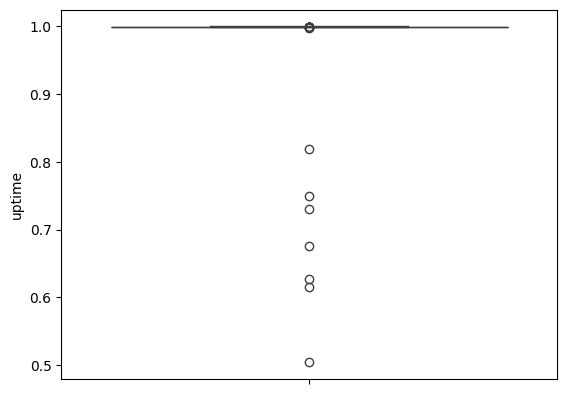

In [66]:
sns.boxplot(burel.query("version == 'v2'")['uptime']) 

### Daily - by Transportation mode

In [67]:
id_var = ['day','version']
evolution = burel.groupby(id_var)[transportation_modes].sum().reset_index()
evolution = pd.melt(evolution, id_vars=id_var, var_name="mode")

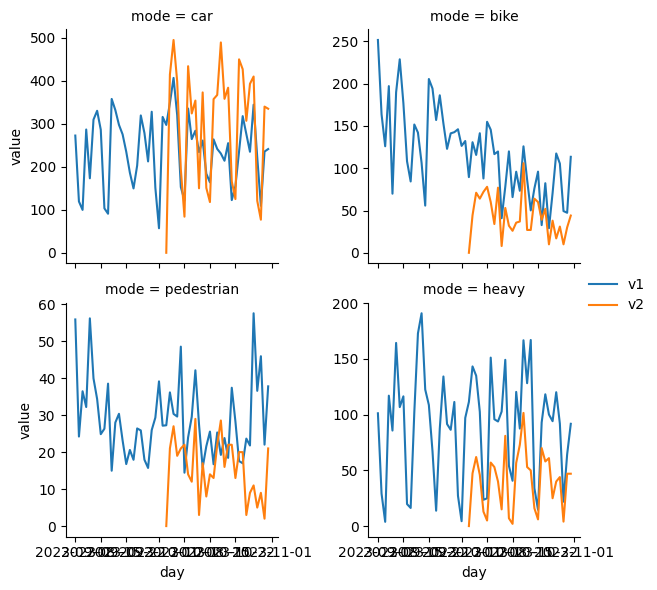

In [68]:
g = sns.FacetGrid(evolution, col="mode", sharey=False, col_wrap=2)
g.map_dataframe(sns.lineplot, x='day', y='value', hue='version', errorbar=None)
g.add_legend()

### Daily - by transportation mode and direction

In [69]:
evolution_direction = burel.groupby(id_var)[direction_modes].sum().reset_index()
evolution_direction['vehicules_lft'] = evolution_direction['car_lft'] + evolution_direction['heavy_lft']
evolution_direction['vehicules_rgt'] = evolution_direction['car_rgt'] + evolution_direction['heavy_rgt']
evolution_direction = pd.melt(evolution_direction, id_vars=id_var, var_name="mode_direction")
evolution_direction[['mode', 'direction']] = evolution_direction['mode_direction'].str.split("_", expand = True)

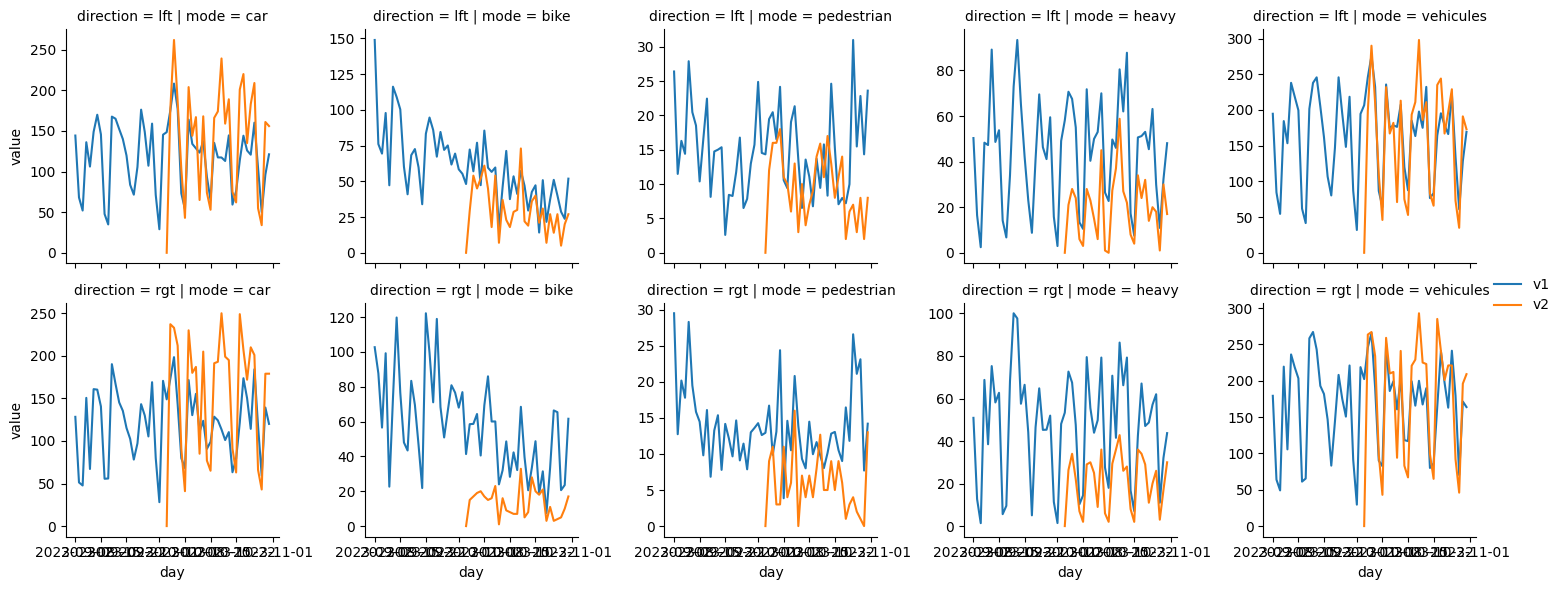

In [70]:
g = sns.FacetGrid(evolution_direction, col="mode", row="direction", sharey=False)
g.map_dataframe(sns.lineplot, x='day', y='value', hue='version', errorbar=None)
g.add_legend()

### Day of week

In [71]:
id_var = ['day_of_week','version']
dow_direction = burel.groupby(id_var, observed=False)[direction_modes].median().reset_index()
dow_direction = pd.melt(dow_direction, id_vars=id_var, var_name="mode_direction")
dow_direction[['mode', 'direction']] = dow_direction['mode_direction'].str.split("_", expand = True)


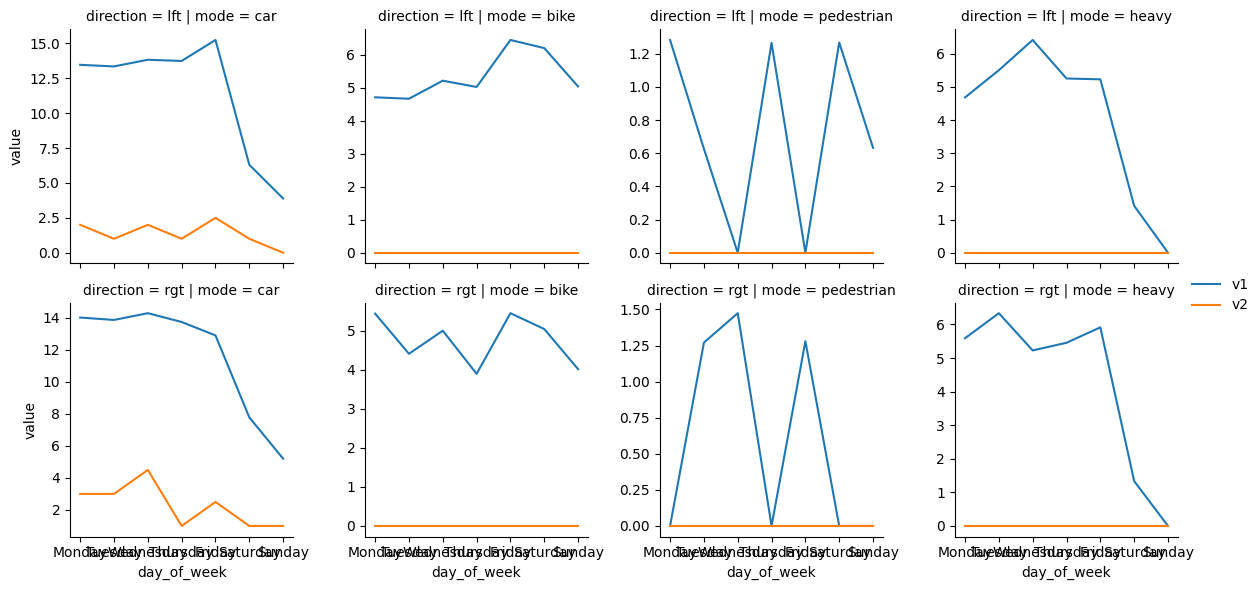

In [72]:
g = sns.FacetGrid(dow_direction, col="mode", row="direction", sharey=False)
g.map_dataframe(sns.lineplot, x='day_of_week', y='value', hue='version', errorbar=None, sort=False)
g.add_legend()

 ### Hourly

In [73]:
id_var = ['hour','version']
hour_direction = burel.groupby(id_var, observed=False)[direction_modes].median().reset_index()
hour_direction = pd.melt(hour_direction, id_vars=id_var, var_name="mode_direction")
hour_direction[['mode', 'direction']] = hour_direction['mode_direction'].str.split("_", expand = True)

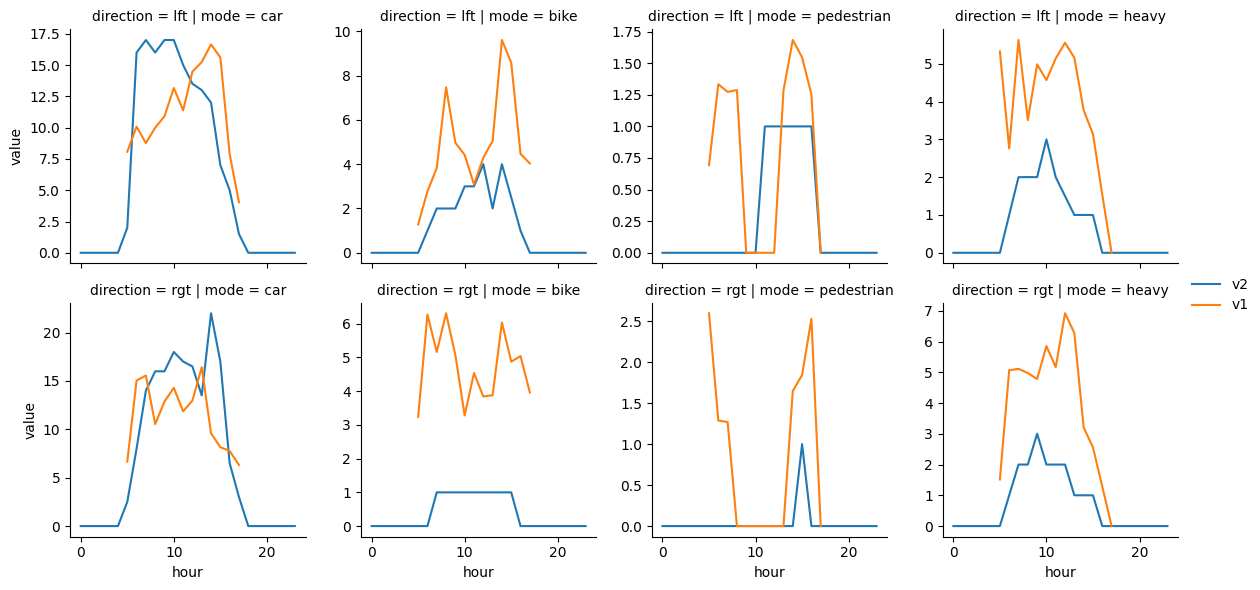

In [74]:
g = sns.FacetGrid(hour_direction, col="mode", row="direction", sharey=False)
g.map_dataframe(sns.lineplot, x='hour', y='value', hue='version', errorbar=None, sort=False)
g.add_legend()